# Deep Reinforcement Learning on Snake
<hr>

Author: [Sahil Johari](http://www.sahiljohari.com/)

TO-DO:
* Add references
* Add comments and clean-up code

## Problem Statement

Deep reinforcement learning (DRL) is poised to revolutionize the field of artificial intelligence (AI) and represents a step toward building autonomous systems with a higher level of understanding of the visual world. Currently, deep learning is enabling reinforcement learning (RL) to scale to problems that were previously intractable, such as learning to play video games directly from pixels.

**Reinforcement learning**, explained simply, is a computational approach where an agent interacts with an environment by taking actions in which it tries to maximize an accumulated reward. Here is a simple graph, which I will be referring to often:

A reinforcement learning problem is characterized by the following components:

* A state space, which is the set of all possible states,
* An action space, which is the set of all possible actions,
* A cost function, which measures how bad a state is,
* A time horizon, which is the number of time steps,
* An initial state probability distribution, which specifies how frequently different states occur at the beginning before any action is taken, and
* A state transition probability distribution, which specifies how the state changes (probabilistically) after a particular action is taken.

<img src="Q_learning.PNG" />

An agent in a current state (St) takes an action (At) to which the environment reacts and responds, returning a new state(St+1) and reward (Rt+1) to the agent. Given the updated state and reward, the agent chooses the next action, and the loop repeats until an environment is solved or terminated.

In this project, I will be implementing a **deep Q-network (DQN)** to play a simple game of *Snake*. The goal is to maximize the score of game in a 10x10 space and modify the DQN to stretch out the performance as much as possible.

## Q-learning and Deep Q-Networks

There are two main approaches to solving RL problems:
* Methods based on value functions
* Methods based on policy search

There is also a hybrid actor-critic approach that employs both value functions and policy search. As far as the scope of this project is concerned, I am going to use the _value functions_ approach to play the Snake game.

In Q-learning, which is a value functions approach, we use a *Q-table* that maps environment states with actions taken on them. For each (state, action) pair, there is a reward that the agent achieves. The idea is to pick a value that maximizes the cumulative reward by the end of an episode. To do this, we use an equation called the *Bellman equation*, which is shown below:

<img src="Bellman_equation.PNG" />

- The agent starts by choosing an action with the highest Q value for the current state using argmax. Argmax will return the index/action with the highest value for that state. Initially, our Q table will be all zeros. But, after every step, the Q values for state-action pairs will be updated.

- The agent then takes action and we store the future state as state2 (St+1). This will allow the agent to compare the previous state to the new state.

- We update the state-action pair (St , At) for Q using the reward, and the max Q value for state2 (St+1). This update is done using the action value formula (based upon the Bellman equation) and allows state-action pairs to be updated in a recursive fashion (based on future values). Note that we still do not have a discount factor included in this model.

This is **Q-learning in a nutshell**. To know more about it, refer the citations at the bottom of this notebook.

A **Deep Q-network**, simply put, is an extension of Q-learning in which the Q-values are approximated using a *deep neural network*. This technique shows a great improvement in the outcome of a reinforcement problem, however, it is not always required. When you have a complex environment space with various factors to consider for an agent to solve it, a DQN would prove to be quite useful.

Now that a basic understanding of the concepts has been established, I would start building the game environment followed by the agent to solve it.

In [1]:
from collections import namedtuple
import itertools as it
import os
from random import sample as rsample
import time

import numpy as np

from sklearn.neural_network import MLPClassifier

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import SGD, RMSprop, Adam

from matplotlib import pyplot as plt
from IPython.display import display, clear_output

Using TensorFlow backend.


## Creating the game

The first step is to create an environment for our agent to operate on. This has been implemented in a simple way using Python coroutines and will be rendered (or displayed) using _Pyplot_ (from Matplotlib). It can also be implemented in a way similar to [OpenAI Gym](https://gym.openai.com/) environments, but I specifically want my own environment to control all the aspects of its execution behavior.

If you are using this notebook, feel free to tinker with the code and possibly improve it. You can find the original source of this code in the **References** section [here](#references).

In [2]:
class Snake(object):
    def __init__(self, rewards, grid_size):
        self.grid_size = grid_size
        self.snake_length = 3
        self.Fruit = namedtuple('Fruit', ['x', 'y'])
        self.life_reward = rewards[0]
        self.alive_reward = rewards[1]
        self.death_reward = rewards[2]
        self.reset()
        
    def reset(self):
        self.actions = [(-1, 0)] * self.snake_length  # An action for each snake segment
        self.head_x = self.grid_size // 2 - self.snake_length // 2
        self.snake = [(x, self.grid_size // 2) for x in range(self.head_x, self.head_x + self.snake_length)]
        self.grow = -1  # Don't start growing snake yet
        self.fruit = self.Fruit(-1, -1)
        
    def play(self):
        self.reset()
        while True:
            # Draw borders
            screen = np.zeros((self.grid_size, self.grid_size))
            screen[[0, -1]] = 1
            screen[:, [0, -1]] = 1
            sum_of_borders = screen.sum()

            # Draw snake
            for segm in self.snake:
                x, y = segm
                screen[y, x] = 1

            # Snake hit into wall or ate itself
            end_of_game = len(self.snake) > len(set(self.snake)) or screen.sum() < sum_of_borders + len(self.snake)
            reward = self.death_reward * end_of_game if end_of_game else self.alive_reward

            # Draw fruit
            if screen[self.fruit.y, self.fruit.x] > .5:
                self.grow += 1
                reward = len(self.snake) * self.life_reward
                while True:
                    self.fruit = self.Fruit(*np.random.randint(1, self.grid_size - 1, 2))
                    if screen[self.fruit.y, self.fruit.x] < 1:
                        break

            screen[self.fruit.y, self.fruit.x] = .5

            action = yield screen, reward, len(self.snake)-self.snake_length

            step_size = sum([abs(act) for act in action])
            if not step_size:
                action = self.actions[0]  # Repeat last action
            elif step_size > 1:
                raise ValueError('Cannot move more than 1 unit at a time')

            self.actions.insert(0, action)
            self.actions.pop()

            # For as long as the snake needs to grow,
            # copy last segment, and add (0, 0) action
            if self.grow > 0:
                self.snake.append(self.snake[-1])
                self.actions.append((0, 0))
                self.grow -= 1

            # Update snake segments
            for ix, act in enumerate(self.actions):
                x, y = self.snake[ix]
                delta_x, delta_y = act
                self.snake[ix] = x + delta_x, y + delta_y

            if end_of_game:
                break

## Modeling an Agent

Now that we have the environment set-up, it is time to create our agent which will play the game. Let us understand the structure and working of this agent.

**Agent Parameters:**
Our agents takes a set of input parameters inorder to build itself on top of them. Here is a list:
* **all_possible_actions**: This is the set of actions which the agent can perform on the snake. The values are (0, 0) No action, (0, 1) Move up, (1, 0) Move right, (0, -1) Move down, (-1, 0) Move left.

* **gamma**: This is the discount factor which we previously saw in the Q-learning section.

* **nb_epochs**: As the agent is using a deep Q-network, it needs a certain number of training iterations to learn how to play, which is specified using this parameter.

* **batch_size**: These are the number of experiences that will be used to train the agent at a time.

* **epsilon**: Epsilon governs the randomness in the actions taken by the agent on the environment. As our agent proceeds with the game and learns something, epsilon is decreased in order to allow the DQN to take actions out of what it has learned.

* **nb_frames**: A sequence of game frames which are used by the DQN during convolution.

* **grid_size**: Specify the play area

* **rewards**: The outcome of actions that the agent will recieve. In this game, there are 3 primary events that occur out of the actions taken- Eat food, Stay alive, Die. Based on the event, a reward is granted to the agent.

* **load_path & save_path**: These parameters are for loading or saving the weights from training the model, so that they can be used as a base to further train the model.

**How it works:**
The agents takes the parameters and uses a _Convolutional Neural Network_ to build a DQN. It then obtains an instance of the game environment and begins training on it. The training process comprises of the following steps:
* For half of the *nb_epochs*, take random actions and capture the game states and rewards - refered as **Experience Replay**.
* While the first half of the training consists of random actions (exploration), the other half is all about the model taking actions, known as _exploitation_.
* The set of experiences are sub-sampled into a batches of size *batch_size*.
* The batches are iterated through and a set of target Q-values are calculated using the _Bellman equation_.
* These Q-values are mapped to the states, which gives us kind of a  Q-table that is fed to the neural network for training.

Once the training process is complete, we test the agent for a certain number of episodes.

In [46]:
class Agent(object):
    def __init__(self, 
                 all_possible_actions,
                 gamma=0.9, 
                 batch_size=32,
                 epsilon=1,
                 nb_frames = 4,
                 grid_size=10,
                 rewards=[5, -1, -10],
                load_path='',
                save_path=''):
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.min_epsilon = 0.3
        self.epsilon_rate = 0.99
        self.action_set = all_possible_actions
        self.nb_actions = len(self.action_set)
        self.rewards = rewards
        self.nb_frames = nb_frames
        self.save_path = save_path
        
        self.grid_size = grid_size

        self.model = self.build_model(load_path)
        
        self.env = Snake(self.rewards, self.grid_size)
        
    def build_model(self, load_path):
        num_filters = [16, 32]
        
        model = Sequential()
        model.add(BatchNormalization(axis=1, input_shape=(self.nb_frames, self.grid_size, self.grid_size)))
        for filters in num_filters:
            model.add(Conv2D(filters=filters, 
                             input_shape = (self.nb_frames, self.grid_size, self.grid_size), 
                             kernel_size=(3,3), 
                             padding='same', 
                             activation='relu'))
            model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.nb_actions, activation='softmax'))
                       
        if load_path!='':
            model.load_weights(load_path)
        model.compile(optimizer=SGD(lr=0.001), loss='mse', metrics=['accuracy'])
        
        return model
    
    def save_weights(self):
        if self.save_path!='':
            self.model.save_weights(self.save_path, overwrite=True)
    
    def model_summary(self):
        print(self.model.summary())
    
    def experience_replay(self, batch_size):
        """
        Coroutine of experience replay.

        Provide a new experience by calling send, which in turn yields 
        a random batch of previous replay experiences.
        """
        memory = []
        while True:
            experience = yield rsample(memory, batch_size) if batch_size <= len(memory) else None
            memory.append(experience)
    

    def train(self, nb_epochs=1000):
        self.exp_replay = self.experience_replay(self.batch_size)
        # Start experience replay coroutine
        next(self.exp_replay)
        
        for i in range(nb_epochs):
            g = self.env.play()
            screen, _, _ = next(g)
            S = np.asarray([screen] * self.nb_frames)
            try:
                # Decrease epsilon over the first half of training
                if self.epsilon > self.min_epsilon:
                    self.epsilon -= self.epsilon_rate / (nb_epochs / 2)

                while True:
                    if np.random.random() < self.epsilon:
                        ix = np.random.randint(self.nb_actions)
                    else:
                        ix = np.argmax(self.model.predict(S[np.newaxis]), axis=-1)[0]

                    action = self.action_set[ix]
                    screen, reward, _ = g.send(action)
                    S_prime = np.zeros_like(S) 
                    S_prime[1:] = S[:-1]
                    S_prime[0] = screen
                    experience = (S, action, reward, S_prime)
                    S = S_prime

                    batch = self.exp_replay.send(experience)

                    if batch:
                        inputs = []
                        targets = []
                        for s, a, r, s_prime in batch:
                            # The targets of unchosen actions are set to the q-values of the model,
                            # so that the corresponding errors are 0. The targets of chosen actions
                            # are set to either the rewards, in case a terminal state has been reached, 
                            # or future discounted q-values, in case episodes are still running.
                            t = self.model.predict(s[np.newaxis]).flatten()
                            ix = self.action_set.index(a)
                            if r < 0:
                                t[ix] = r
                            else:
                                t[ix] = r + self.gamma * self.model.predict(s_prime[np.newaxis]).max(axis=-1)
                            targets.append(t)
                            inputs.append(s)

                        self.model.train_on_batch(np.array(inputs), np.array(targets))    

            except StopIteration:
               pass
            
            if i==0 or (i+1) % 1000 == 0:
                print('Epoch %6i/%i, epsilon: %.3f' % (i + 1, nb_epochs, self.epsilon))
                self.save_weights()
        
        print('Training complete..\n')

    def render(self, render=False, save=False):
        if save:
            if 'images' not in os.listdir('.'):
                os.mkdir('images')
        
        frame_cnt = it.count()
        while True:
            screen = (yield)
            if render:
                clear_output(wait=True)
                plt.imshow(screen, interpolation='none', cmap='gray')
                display(plt.show())
            
            if save:
                plt.imshow(screen, interpolation='none', cmap='gray')
                plt.savefig('images/%04i.png' % (next(frame_cnt), ))
    
    
    def test(self, render, nb_episodes=10):
        img_saver = self.render(render)
        next(img_saver)
        
        scores = []
        self.max_episode_length = 100
        
        for _ in range(nb_episodes):
            alive_reward_cap = 0

            g = self.env.play()
            screen, _, init_score = next(g)
            img_saver.send(screen)
            frame_cnt = it.count()
            try:
                S = np.asarray([screen] * self.nb_frames)
                while True:
                    next(frame_cnt)
                    ix = np.argmax(self.model.predict(S[np.newaxis]), axis=-1)[0]
                    screen, r, score = g.send(self.action_set[ix])
                    S[1:] = S[:-1]
                    S[0] = screen
                    img_saver.send(screen)

                    if r % 5 == 0:
                        alive_reward_cap = 0
                    elif r == -1:
                        alive_reward_cap += 1

                    if alive_reward_cap > self.max_episode_length * (score+1):
                        raise StopIteration

            except StopIteration:
                scores.append(score)
                
        img_saver.close()
        return scores
        

## Let's play!

Now that we have all the necessary code in place, its time to train the agent and test it after that.

The way this is implemented is - For a certain number of attempts, the agent will play the game for some episodes and the scores will be collected for each of them. If the maximum score out of those episode scores is less than a minimum score (of 5), then the agent will be trained for, say 5000 epochs. This will go on until the maximum score achieved is more than 5.

In [51]:
def playSnake(training_iterations=1000, 
              test_episodes=10,
              show_model=False):
    
    params = dict(
        all_possible_actions=((0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)),
                     gamma=0.8, 
                     batch_size=64,
                     epsilon=1,
                     nb_frames = 2,
                     grid_size=10,
                     rewards=[5, -1, -10],
                    load_path='game_weights/snake_game_weights_v2.h5',
                    save_path=''
    )

    target_score = 8
    max_scores = []
    attempts = 2
    
    agent = Agent(**params)
    
    if show_model:
        agent.model_summary()
    
    for attempt in range(attempts):
        # ====Testing the model====
        scores = agent.test(render=False, nb_episodes=test_episodes)
        max_scores.append(max(scores))
        
        if max(scores) == target_score:
            print("\n==========\nTarget achieved successfully!\n==========")
            plt.bar(range(len(scores)),scores)
            break
        
        if max(scores) <= 5:
            # ====Training the model====
            print('\n-----Commencing Training process-----')
            agent.train(nb_epochs=training_iterations)
            
    if attempts > 1:
        plt.title('Max. Scores per iteration')
        plt.plot(max_scores, label='Max scores per attempt')
    else:
        plt.title('Score summary per episode')
        plt.bar(range(len(scores)),scores)


-----Commencing Training process-----
Epoch      1/5000, epsilon: 1.000
Epoch   1000/5000, epsilon: 0.604
Epoch   2000/5000, epsilon: 0.300
Epoch   3000/5000, epsilon: 0.300
Epoch   4000/5000, epsilon: 0.300
Epoch   5000/5000, epsilon: 0.300
Training complete..


-----Commencing Training process-----
Epoch      1/5000, epsilon: 0.300
Epoch   1000/5000, epsilon: 0.300
Epoch   2000/5000, epsilon: 0.300
Epoch   3000/5000, epsilon: 0.300
Epoch   4000/5000, epsilon: 0.300
Epoch   5000/5000, epsilon: 0.300
Training complete..


-----Commencing Training process-----
Epoch      1/5000, epsilon: 0.300
Epoch   1000/5000, epsilon: 0.300
Epoch   2000/5000, epsilon: 0.300
Epoch   3000/5000, epsilon: 0.300
Epoch   4000/5000, epsilon: 0.300
Epoch   5000/5000, epsilon: 0.300
Training complete..


-----Commencing Training process-----
Epoch      1/5000, epsilon: 0.300
Epoch   1000/5000, epsilon: 0.300
Epoch   2000/5000, epsilon: 0.300
Epoch   3000/5000, epsilon: 0.300
Epoch   4000/5000, epsilon: 0.300

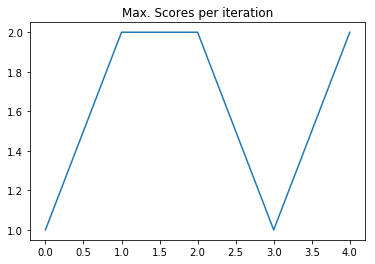

In [48]:
playSnake(training_iterations=5000, test_episodes=50)

We can see that there is some progress made by the agent after training. Let's train it more!


-----Commencing Training process-----
Epoch      1/2000, epsilon: 0.999
Epoch   1000/2000, epsilon: 0.299
Epoch   2000/2000, epsilon: 0.299
Training complete..


-----Commencing Training process-----
Epoch      1/2000, epsilon: 0.299
Epoch   1000/2000, epsilon: 0.299
Epoch   2000/2000, epsilon: 0.299
Training complete..


-----Commencing Training process-----
Epoch      1/2000, epsilon: 0.299
Epoch   1000/2000, epsilon: 0.299
Epoch   2000/2000, epsilon: 0.299
Training complete..



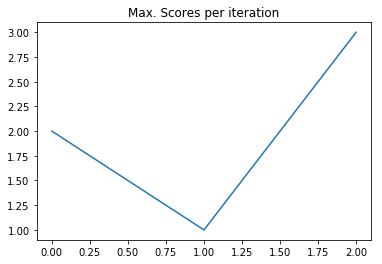

In [50]:
playSnake(training_iterations=2000, test_episodes=50)

Alright! A slight improvement in the highest score. Probably training it a lot would make the agent play better.

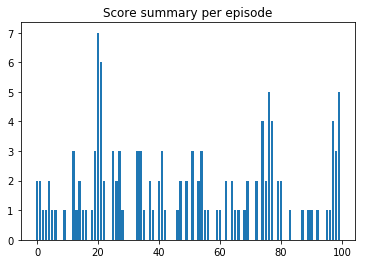

In [20]:
playSnake(test_episodes=100)

In [3]:
# Run this cell to view a demo
from IPython.display import HTML
HTML('<img src="output_WX5pMq.gif">')

**Truth is out there!**
After training for about 30,000 training epochs and testing for 100 episodes, the agent could achieve a highest score of 7.

I have stored the weights from the training, which can be loaded directly into the model and tested.
<hr>

The performance can be improved in various ways, however, as per my experience during this project there is a minimal tuning that can be done by changing the following:

* Model (Training parameters)
* Reward values
* Training iterations
* Randomness (epsilon)

In this problem, changing the reward values and randomness gave me better results than before. Furthermore, I changed the number of frames to be sent for training, which is a model input parameter of my DQN. A lot more tweaking can be done which might improve/degrade the results.

Common Observations about the game:
* In most episodes, the snake takes a fixed set of moves, getting stuck in a loop.
* If the snake keeps growing well, it usually bumps into itself and dies.
* The snake is very good at avoiding walls, but sometimes avoids food as well.

## Conclusion

In this project, I have applied the concept of deep reinforcement learning on the classic game - Snake. I used the approach called Q-learning, which is based on value functions that estimates the expected return of being in a given state. I extended this approach to deep Q-network and used a convolutional neural network to implement it. Using this approach, the maximum score I could achieve was 7 (seven).

## Future Work

This project can be further extended using concepts like _Policy search_ and _Actor-Critic method_. An interesting implementation would be to incorporate *Genetic algorithm* to create a population of agents and filter out the best through various generations.

## References
<a id='references'></a>
* [Basic Reinforcement Learning by Víctor Mayoral Vilches](https://github.com/vmayoral/basic_reinforcement_learning/blob/master/tutorial6/examples/Snake/snake.py)

* [Interactive Python Notebook for RL in Catch](https://gist.github.com/cadurosar/bd54c723c1d6335a43c8)